In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

import sys
sys.path.append("/Users/carlosnavarrete/Documents/Repos/PolaPy")

from polapy.competitiveness import election_competitiveness as competitiveness
from polapy.polarization import election_polarization as polarization

os.chdir("../")

from epitools import get_data
from plots import set_plot

In [2]:
def bake_data(input_df, unit, aggregation="polling_id"):
    dd = input_df.groupby([unit, aggregation, "candidate"]).agg({"value": "sum"})
    dd["rate"] = dd.groupby(level=[0, 1], group_keys=False).apply(lambda x: x/x.sum())
    dd = dd.reset_index().rename(columns={aggregation: "polling_id"})
    
    return dd

In [27]:
country, year, election_round, aggregation, second_aggregation = "France", 2022, "first_round", "nuts_2", "commune_id"
# country, year, election_round, aggregation, second_aggregation = "Chile", 2021, "first_round", "region_id", "commune"
# country, year, election_round, aggregation, second_aggregation = "United States", 2020, "general", "state", "county_fips"

# country = "United States"
# year = 2020
# election_round = "general"
# aggregation = "state"

df = pd.read_csv(
    f"data_output/{country}/{year}_{election_round}_polling_station.csv.gz",
    compression="gzip"
)

df_location = pd.read_csv(
    f"data_output/{country}/{year}_{election_round}_polling_station_location.csv.gz",
    compression="gzip"
)

df = pd.merge(
    df.query("flag_candidates == 1"),
    df_location,
    on="polling_id"
)

if country == "France":
    candidates = df.groupby("candidate").agg({"value": "sum"}).sort_values("value", ascending=False).head(8).index
    df = df[df["candidate"].isin(candidates)]
    df["commune_id"] = df.apply(lambda x: f"75-{x['circunscription_id']}" if x["department_id"] == "75" else x["commune_id"], axis=1)

elif country == "United States":
    df = df[df["candidate"].isin(["JOSEPH R BIDEN", "DONALD J TRUMP"])].drop_duplicates()

df.head()

/var/folders/hb/15069ggs0pj__x0wzwkvgz2h0000gn/T/ipykernel_76876/1727706763.py:15: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_location = pd.read_csv(


,polling_id,candidate,rate,value,rank,flag_candidates,department_id,department,circunscription_id,circunscription,commune_id,commune,polling_place,electors,abstentions,nuts_3,nuts_1_name,nuts_2_name,nuts_2,nuts_1
1,01-1-0001,Emmanuel MACRON,0.288462,150,1.0,1,01,Ain,4,4ème circonscription,01001,L'Abergement-Clémenciat,0001,645,108,FRK21,Auvergne-Rhône-Alpes,Rhône-Alpes,FRK2,FRK
2,01-1-0001,Fabien ROUSSEL,0.011538,6,9.0,1,01,Ain,4,4ème circonscription,01001,L'Abergement-Clémenciat,0001,645,108,FRK21,Auvergne-Rhône-Alpes,Rhône-Alpes,FRK2,FRK
3,01-1-0001,Jean LASSALLE,0.034615,18,8.0,1,01,Ain,4,4ème circonscription,01001,L'Abergement-Clémenciat,0001,645,108,FRK21,Auvergne-Rhône-Alpes,Rhône-Alpes,FRK2,FRK
4,01-1-0001,Jean-Luc MÉLENCHON,0.126923,66,3.0,1,01,Ain,4,4ème circonscription,01001,L'Abergement-Clémenciat,0001,645,108,FRK21,Auvergne-Rhône-Alpes,Rhône-Alpes,FRK2,FRK
5,01-1-0001,Marine LE PEN,0.286538,149,2.0,1,01,Ain,4,4ème circonscription,01001,L'Abergement-Clémenciat,0001,645,108,FRK21,Auvergne-Rhône-Alpes,Rhône-Alpes,FRK2,FRK


In [28]:
bake_data(df, aggregation, aggregation=second_aggregation)

,nuts_2,polling_id,candidate,value,rate
0,FR10,75-1,Emmanuel MACRON,31799,0.426672
1,FR10,75-1,Fabien ROUSSEL,872,0.011700
2,FR10,75-1,Jean LASSALLE,943,0.012653
3,FR10,75-1,Jean-Luc MÉLENCHON,17783,0.238608
4,FR10,75-1,Marine LE PEN,5258,0.070551
...,...,...,...,...,...
279723,FRY5,ZM617,Jean-Luc MÉLENCHON,520,0.318823
279724,FRY5,ZM617,Marine LE PEN,687,0.421214
279725,FRY5,ZM617,Valérie PÉCRESSE,139,0.085224
279726,FRY5,ZM617,Yannick JADOT,17,0.010423


In [29]:
df_a = bake_data(df, aggregation, aggregation=second_aggregation)
df_b = df.copy()

def get_ep_ec(input_df, aggregation, level):
    output = []
    for unit, tmp in input_df.groupby(aggregation):
        v_ec, ag = competitiveness(tmp, unit="polling_id", votes="value")
        v_ep, ag = polarization(tmp, unit="polling_id", votes="value")
    
        output.append({
            "geography_id": unit,
            "ec": v_ec,
            "ep": v_ep,
            "level": level
        })

    return pd.DataFrame(output)

df_a_ep = get_ep_ec(df_a, aggregation, level="Commune")
df_b_ep = get_ep_ec(df_b, aggregation, level="Precinct")

/Users/carlosnavarrete/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/carlosnavarrete/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/carlosnavarrete/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not

In [30]:
data = pd.concat([df_a_ep, df_b_ep])

if country == "France":
    data = data[~data["geography_id"].str.contains("FRZ")]
    data = data[~data["geography_id"].str.contains("FRY")]

elif country == "United States":
    data = data[~data["geography_id"].str.contains("DC")]
    data = data[~data["geography_id"].str.contains("DISTRICT OF COLUMBIA")]

data.head()

,geography_id,ec,ep,level
0,FR10,0.843825,0.049699,Commune
1,FRB0,0.860421,0.032144,Commune
2,FRC1,0.861606,0.033760,Commune
3,FRC2,0.860155,0.037909,Commune
4,FRD1,0.858504,0.030735,Commune


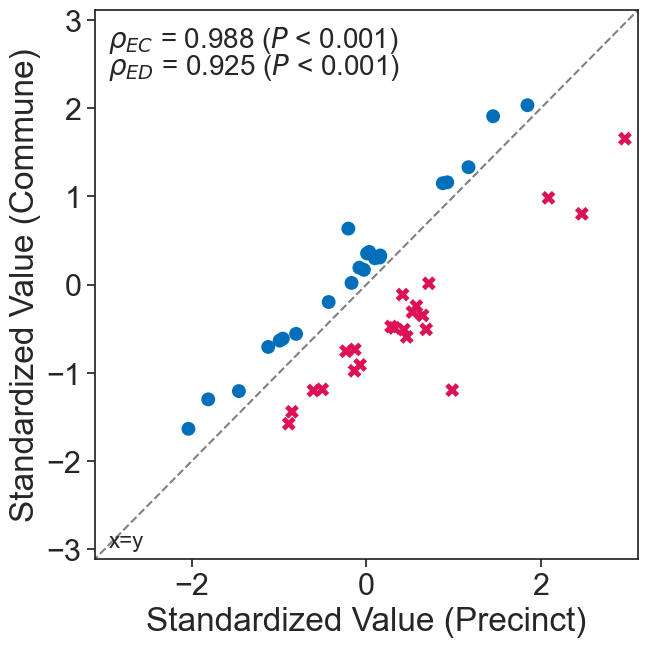

In [31]:
data2 = data.copy()
for col in ["ep", "ec"]:
    data2[col] = (data2[col] - data2[col].mean()) / data2[col].std()

data2 = data2.melt(id_vars=["geography_id", "level"], var_name="type")\
    .pivot(index=["geography_id", "type"], columns=["level"], values="value").reset_index()

data2 = data2.rename(columns={"Precinct": "x", "Commune": "y"})

sns.set(font_scale=2, style="ticks")

fig, ax = plt.subplots(figsize=(7, 7))
set_plot(data2.dropna(subset=["x", "y"]), ax, xlabel="Standardized Value (Precinct)", ylabel="Standardized Value (Commune)", labelkey=None)

fig.tight_layout()